# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [17]:
# Importamos librerías
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    closes = web.DataReader(tickers, start=start_date, end=end_date, data_source='yahoo')['Adj Close']
    closes = closes.sort_index()
    return closes

In [3]:
# Descargamos datos...
# Instrumento: Apple
instrumento = "AAPL"
# Fechas de interés (inicio y fin): 2010-2019
start = "2010-01-01"
end = "2019-12-31"

In [4]:
# Obtenemos precios
closes = get_closes(tickers=instrumento,
                    start_date=start,
                    end_date=end)

In [6]:
# Primeros precios
closes.head()

Date
2010-01-04    6.572422
2010-01-05    6.583784
2010-01-06    6.479061
2010-01-07    6.467082
2010-01-08    6.510078
Name: Adj Close, dtype: float64

In [7]:
# Ultimos precios
closes.tail()

Date
2019-12-24    70.234581
2019-12-26    71.628067
2019-12-27    71.600876
2019-12-30    72.025833
2019-12-31    72.552094
Name: Adj Close, dtype: float64

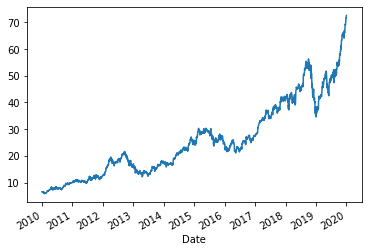

In [5]:
# Graficamos
closes.plot();

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [8]:
# Calcular rendimientos diarios y graficarlos
# ret = (closes - closes.shift()) / closes.shift()
ret = closes.pct_change().dropna()

In [9]:
# Primeros rendimientos
ret.head()

Date
2010-01-05    0.001729
2010-01-06   -0.015906
2010-01-07   -0.001849
2010-01-08    0.006648
2010-01-11   -0.008821
Name: Adj Close, dtype: float64

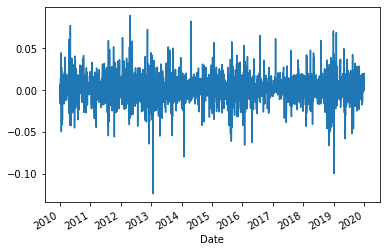

In [10]:
# Gráfico de rendimiento
ret.plot();

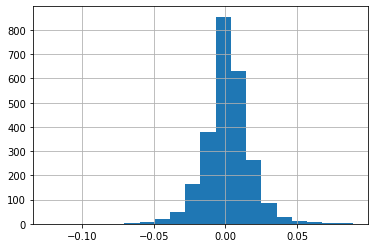

In [12]:
ret.hist(bins=20);

Entonces, suponemos que la diferencia logaritmica de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [15]:
# Calculamos media y desviación estándar
mu, sigma = ret.mean(), ret.std()
mu, sigma

(0.0010870240419151478, 0.016219941536048575)

In [20]:
z = np.linspace(-0.1, 0.1, 100)
f = np.exp(-(z - mu)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi * sigma**2))

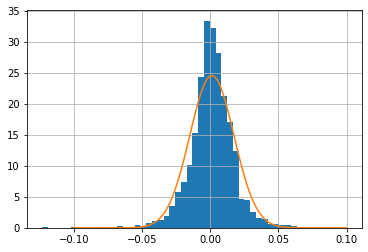

In [24]:
ret.hist(bins=50, density=True)
plt.plot(z, f)

Parece ser que nuestra suposición de que los rendimientos distribuyen normal, no es una suposición muy alejada de la realiad.

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2016, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2017 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios rendimientos diarios y que devuelva un dataframe con esta simulación.

In [26]:
# Ayuda en la función np.random.normal
help(np.random.normal)

Help on built-in function normal:

normal(...) method of numpy.random.mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)
    
    Draw random samples from a normal (Gaussian) distribution.
    
    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).
    
    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.
    
    .. note::
        New code should use the ``normal`` method of a ``default_rng()``
        instance instead; see `random-quick-start`.
    
    Parameters
    ----------
    loc : float or array_like of floats
        Mean ("centre") of the distribution.
    scale : fl

In [30]:
# Función que simula varios escenarios de rendimientos diarios
def simulate_daily_ret(mu, sigma, n_days, n_scen, start_date):
    dates = pd.date_range(start=start_date, periods=n_days, freq="B")
    return pd.DataFrame(np.random.normal(loc=mu, scale=sigma, size=(n_days, n_scen)), index=dates)

In [52]:
# Simulamos 100 escenarios para todo el 2020
n_scen = 10000
n_days = 252
sim_ret = simulate_daily_ret(mu, sigma, n_days, n_scen, "2020-01-01")
sim_ret

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2020-01-01,0.008738,-0.008845,0.040066,0.021370,0.001821,-0.010181,-0.002622,0.026765,0.016325,0.010498,...,-0.017501,0.002387,-0.009051,-0.005317,0.001706,0.016926,0.006040,-0.005398,-0.010356,-0.012014
2020-01-02,0.008232,0.013626,-0.010909,0.020965,0.003685,0.006525,-0.014277,-0.015127,-0.012247,0.013325,...,0.014123,-0.024606,0.013364,0.010782,-0.030693,0.003510,-0.008952,0.019691,0.018919,-0.008778
2020-01-03,0.008326,0.035665,0.008803,0.002930,-0.000040,0.016712,-0.009062,-0.012211,0.000393,0.000814,...,-0.016777,0.009971,-0.024705,0.013176,-0.024566,-0.000471,-0.001864,0.030411,0.030684,0.005335
2020-01-06,-0.008996,-0.021165,-0.014558,0.001376,-0.006585,0.020577,0.014396,0.006326,-0.000719,0.013944,...,-0.002572,-0.026657,0.005666,-0.010830,-0.018633,0.003968,-0.011655,-0.026495,0.006795,-0.008058
2020-01-07,-0.005691,0.014258,-0.006781,-0.010849,0.012831,-0.005000,0.001367,-0.003235,0.010267,0.024418,...,-0.009788,-0.000611,0.012154,0.035984,0.017092,-0.030977,0.003820,-0.019825,-0.012893,-0.006325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-11,0.001258,-0.032347,-0.000307,0.008401,-0.002235,-0.024198,-0.026047,0.025685,-0.023646,0.006339,...,-0.022702,-0.018857,0.008627,0.000940,0.013430,-0.011348,0.019693,-0.009633,-0.024114,0.017824
2020-12-14,0.002295,0.016244,-0.003562,-0.009071,0.000194,0.022425,0.001758,0.015052,0.036937,-0.007746,...,0.012104,0.014336,-0.007830,0.005824,-0.003020,0.009224,0.014727,-0.023782,0.001909,-0.013512
2020-12-15,-0.012160,-0.025661,-0.009186,0.018232,-0.004926,-0.007811,-0.007642,-0.018289,-0.030910,0.000326,...,-0.029289,0.011128,0.031227,0.003419,0.026377,0.014330,-0.008716,0.003144,0.012172,0.007804
2020-12-16,-0.006211,0.010608,0.025526,-0.004661,0.020345,0.000147,-0.017293,-0.007929,0.012099,-0.021097,...,-0.000946,0.002254,0.008540,0.010585,0.021971,0.002930,-0.003572,0.012741,0.014323,0.004565


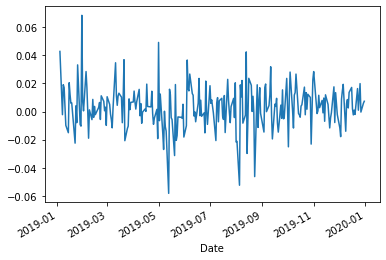

In [53]:
ret.iloc[-250:].plot();

In [54]:
# Mostrar
# sim_ret.plot(legend=False)

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}\exp(r_0+\cdots+r_{k})$, donde $p_{-1}$ es el último precio reportado en el 2016.

Con los rendimientos, calculamos los precios de cierre...

In [55]:
closes.iloc[-1]

72.55209350585938

In [56]:
sim_closes = closes.iloc[-1] * (1 + sim_ret).cumprod()

In [57]:
# Obtenemos los precios
# sim_closes

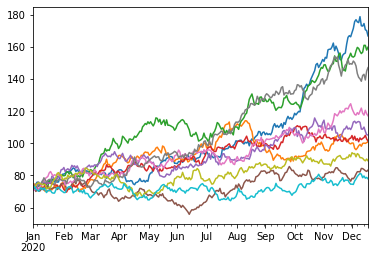

In [47]:
# sim_closes.plot(legend=False);

Concatenamos y graficamos...

In [58]:
# Concatenar y graficar
# closes_cat = pd.concat((closes.iloc[-252:], sim_closes), axis=0)
# closes_cat.plot(legend=False)

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [61]:
# Umbral de 10% del ultimo precio
K = 1.1 * closes.iloc[-1]
# Fechas
dates = pd.date_range(start="2020-01-01", periods=n_days, freq="B")
# DataFrame de Strikes
strike = pd.DataFrame(K * np.ones((n_days, n_scen)), index=dates)
# Concatenar y graficar
# sim_closes_cat_strikes = pd.concat([closes_cat, strike])
# sim_closes_cat_strikes.plot(legend=False);

In [62]:
sim_closes

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2020-01-01,73.186069,71.910364,75.458959,74.102565,72.684200,71.813472,72.361859,74.493972,73.736513,73.313766,...,71.282370,72.725300,71.895425,72.166301,72.675897,73.780115,72.990296,72.160444,71.800716,71.680440
2020-01-02,73.788564,72.890199,74.635767,75.656130,72.952052,72.282072,71.328719,73.367097,72.833431,74.290697,...,72.289073,70.935819,72.856258,72.944421,70.445238,74.039061,72.336882,73.581353,73.159101,71.051252
2020-01-03,74.402957,75.489820,75.292800,75.877805,72.949106,73.490067,70.682370,72.471207,72.862091,74.351155,...,71.076247,71.643145,71.056333,73.905511,68.714704,74.004185,72.202053,75.819065,75.403898,71.430313
2020-01-06,73.733626,73.892099,74.196664,75.982180,72.468753,75.002264,71.699917,72.929650,72.809726,75.387918,...,70.893417,69.733370,71.458922,73.105112,67.434340,74.297852,71.360541,73.810264,75.916299,70.854695
2020-01-07,73.313986,74.945653,73.693538,75.157858,73.398574,74.627225,71.797941,72.693749,73.557269,77.228732,...,70.199489,69.690742,72.327463,75.735730,68.586922,71.996294,71.633128,72.346956,74.937504,70.406542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-11,85.674288,124.907575,73.747738,111.076137,83.637962,82.883800,66.827281,94.360904,100.346179,77.674951,...,91.353622,77.192220,73.278315,72.787630,67.224759,132.248281,59.943896,63.964843,46.891285,99.969270
2020-12-14,85.870948,126.936536,73.485025,110.068567,83.654146,84.742493,66.944745,95.781251,104.052673,77.073305,...,92.459355,78.298839,72.704539,73.211558,67.021709,133.468075,60.826716,62.443602,46.980782,98.618487
2020-12-15,84.826796,123.679176,72.809984,112.075334,83.242054,84.080544,66.433153,94.029501,100.836456,77.098437,...,89.751323,79.170142,74.974893,73.461845,68.789544,135.380638,60.296536,62.639947,47.552650,99.388099
2020-12-16,84.299913,124.991182,74.668559,111.552956,84.935596,84.092871,65.284319,93.283935,102.056498,75.471911,...,89.666379,79.348554,75.615181,74.239462,70.300891,135.777357,60.081181,63.438028,48.233733,99.841777


In [63]:
strike

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2020-01-01,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,...,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303
2020-01-02,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,...,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303
2020-01-03,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,...,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303
2020-01-06,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,...,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303
2020-01-07,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,...,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-11,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,...,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303
2020-12-14,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,...,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303
2020-12-15,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,...,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303
2020-12-16,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,...,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303,79.807303


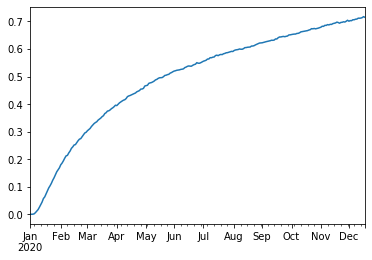

In [65]:
# Comparar cada escenario en cada fecha
comp = sim_closes > strike
# Sumamos para cada fecha y dividimos entre el número de escenarios
prob = comp.sum(axis=1) / n_scen
# Gráfico de probabilidad
prob.plot();

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

# Martes 29 de junio no hay clase
# Viernes 2 de julio clase de reposición: Asesoría para el proyecto (módulo 2)

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>